cuda:0
Files already downloaded and verified
Files already downloaded and verified
Evaluate fitnesses before generation loop..
Calc for Individual


/tmp/ipykernel_702500/659027247.py:114: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(final_layer.weight)
/user/HS400/ac02351/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/user/HS400/ac02351/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


For entire training set, total samples: 50000, correct predictions: 2956, accuracy: 5.912
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 5431, accuracy: 10.862
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 4012, accuracy: 8.024000000000001
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 1755, accuracy: 3.51
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 4432, accuracy: 8.863999999999999
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 1927, accuracy: 3.8539999999999996
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 4011, accuracy: 8.022
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 4208, accuracy: 8.416
Calc for Individual
For entire training set, total samples: 50000, correct predictions: 8616, accuracy:

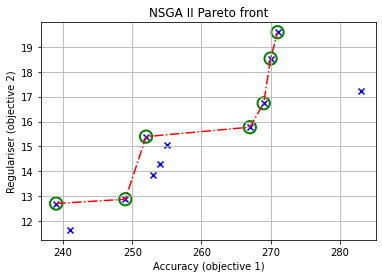

Test Accuracy:  27.279999999999998


In [2]:
#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import numpy

from math import sqrt
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__

#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

PopModel=Net()
PopModel.to(device)

PATH = ('./40_epoch_32_batch_SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))
final_layer = PopModel.classifier[-1]

criterion = nn.CrossEntropyLoss()
nn.init.xavier_uniform(final_layer.weight)

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)
NDIM = 530
toolbox = base.Toolbox()

def evaluateModel():
    runningValLoss=0.0
    total=0.0
    PopModel.eval()
    correct_predictions=0.0
    total_samples=0.0
    correct_predictions=0.0
    # Forward pass to get predictions
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            prediction = PopModel(images)
            loss=criterion(prediction, labels)
            runningValLoss=loss.item()
            _, predicted = torch.max(prediction.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100*(correct_predictions / total_samples)
    return accuracy

def calcFitness(individual):
    weights = numpy.square(numpy.array(individual))
    particleweightsNP1 = numpy.array(individual)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    #converting to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    #converting to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    #setting the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    print("Calc for Individual")
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            outputs = PopModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    accuracy = 100*(correct_predictions / total_samples)
    print(f"For entire training set, total samples: {total_samples}, correct predictions: {correct_predictions}, accuracy: {accuracy}")
    regularizer = numpy.sum(weights)

    return accuracy, regularizer    
    
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxTwoPoint)
flipProb=1.0/9
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 100
    MU =  100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    #evaluating the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    print("Evaluate fitnesses before generation loop..")
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    #assigning crowding distance to the individuals
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    #beginning the generational process
    for gen in range(1, NGEN):
        #vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #making pairs of all (even,odd) in offspring
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        #evaluating the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        print(f"Evaluate fitnesses at {NGEN} generation..")
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            print(f"Fitness for individual is {fit}")
            ind.fitness.values = fit

        #selecting the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook
        
if __name__ == "__main__":
    pop, stats = main()
    # Clone a all individual from a current popoulation
    popclone = list(map(toolbox.clone, pop))

    pop.sort(key=lambda x: x.fitness.values)
    
    # print some individuals
    for n in range(10):
        i=pop[random.choice(range(0, len(pop)))]
        x1=i[0:4]
        x2=i[4:7]
        x3=i[7:9]
        x1= int("".join(str(i) for i in x1),2)
        x2= int("".join(str(i) for i in x2),2)
        x3= int("".join(str(i) for i in x3),2)
        print(x1,x2,x3)
    
    # get a first non dominate individuals in all an optimal solutions
    first_front = tools.sortNondominated(individuals=popclone,k=len(popclone), first_front_only=True)[0]
    best_weights = first_front[0]
    # sort each individual by its ftiness values
    first_front.sort(key= lambda x: x.fitness.values)
    popclone.sort(key = lambda x: x.fitness.values)

    # get both fitness values of each individual in an array
    # all individual
    all_fronts = numpy.array([ind.fitness.values for ind in popclone])
    # Non dominated individual
    first_front = numpy.array([ ind.fitness.values for ind in first_front])


    fig , (ax) = plt.subplots(ncols=1, nrows=1)
    ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
    ax.scatter(first_front[:,0], first_front[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
    ax.plot(first_front[:,0], first_front[:,1], c='r', linestyle='dashdot')
    ax.set_title("NSGA II Pareto front")
    ax.set_xlabel('Accuracy (objective 1)')
    ax.set_ylabel("Regulariser (objective 2)")
    ax.grid()
    #plt.axis("tight")
    figure = ax.get_figure()
    plt.show()

    #set the weights in the model
    weights = numpy.square(numpy.array(best_weights))
    particleweightsNP1 = numpy.array(best_weights)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    # Convert to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    # Convert to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Set the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    #evaluate the model
    accuracy = evaluateModel()

    print("Test Accuracy: ", accuracy)

In [3]:
gen = stats.select("gen")
evals = stats.select("evals")
std = stats.select("std")
avg = [x[0] for x in stats.select("avg")]
min_fit = [x[0] for x in stats.select("min")]
max_fit = [x[0] for x in stats.select("max")]

csv_filename = "training_log_7.csv"

with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["gen", "evals", "std", "min", "avg", "max"])
    csv_writer.writerows(zip(gen, evals, std, min_fit, avg, max_fit))

print(f"Logbook exported to {csv_filename}")

Logbook exported to training_log_7.csv


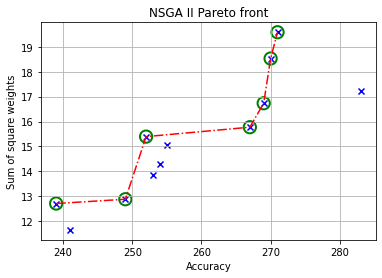

In [4]:
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
ax.scatter(first_front[:,0], first_front[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
ax.plot(first_front[:,0], first_front[:,1], c='r', linestyle='dashdot')
ax.set_title("NSGA II Pareto front")
ax.set_xlabel('Accuracy')
ax.set_ylabel("Sum of square weights")
ax.grid()
#plt.axis("tight")
figure = ax.get_figure()
plt.show()
figure.savefig("fig2.pdf")

In [5]:
print("All fronts, ", all_fronts)
print("First front, ", first_front)

All fronts,  [[239.     12.706]
 [241.     11.646]
 [249.     12.878]
 [252.     15.394]
 [253.     13.86 ]
 [254.     14.302]
 [255.     15.04 ]
 [267.     15.772]
 [269.     16.734]
 [270.     18.53 ]
 [271.     19.586]
 [283.     17.232]]
First front,  [[239.     12.706]
 [249.     12.878]
 [252.     15.394]
 [267.     15.772]
 [269.     16.734]
 [270.     18.53 ]
 [271.     19.586]]


In [6]:
with open('all_fronts.csv', 'a', newline='') as file:
    newWriter = csv.writer(file)
    newWriter.writerows([all_fronts])